# Sentiment Analysis

This project is devoted to analyzing the sentiments or the satisfaction of customers in using the hotel or restaurant services. In this model, an analysis on the comments left in Yelp is employed to predict the stars rating results. In detail, this is a classification task of separating between negative comments and the positive ones; this is also called a binary classification. In this project, I consider also the multiple classification where this is also based on the text content of the reviews including the label positive or negative as the previous model, and a neutral.
Deep neural network and sequence model using RNN architecture, specially bidirectional LSTM model are employed in this project.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud
import re
import string
from nltk.corpus import stopwords
from nltk import FreqDist
import nltk
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import tensorflow as tf
import urllib.request
plt.style.use("fivethirtyeight")

## 1. Data preprocessing

### 1.1. Creation dataset reviews.csv with 20,000 lines


---
In this part, I extracted 20,000 lines from the original dataset yelp_reviews. The original dataset is available on the Yelp challenge website, which requires creating account to download. While this dataset is huge, I decided to extract a small part in order to feed in these models belows.

So, this part will be ignored by setting under types of comment and a csv file is provided instead of the original one.



In [0]:
# path_json = 'yelp_academic_dataset_review.json'
# reader = pd.read_json(path_json, lines = True, chunksize = 100000)

In [0]:
# data = [chunk for (i, chunk) in enumerate(reader) if i < 10]

In [0]:
## Creating csv dataset

# df = pd.concat(data)
# df.reset_index(drop = True, inplace = True)
# df.to_csv('reviews.csv', index = False)

### 1.2. Importing dataset and dropping N/A

In [32]:
# Download data from google drive
urllib.request.urlretrieve(
    "https://drive.google.com/uc?export=download&id=1ixYx_iTlbO3R1IR1RRf9igsbDtH579Ua", 
    "reviews.csv"
)

('reviews.csv', <http.client.HTTPMessage at 0x7feefc2c8b70>)

In [0]:
# Read in the data
df = pd.read_csv('reviews.csv')

In [0]:
# Drop missing values
df.dropna(inplace = True)

In [35]:
df.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,_98ojJ8WyD_3pxus8XQhwQ,0,2017-12-12,0,kMDq0NXaiW7HUP9ZRTrLpQ,5,After finding Friendly's on Yelp and sending a...,0,9cTIkuwnJW4gi8Gwrep2EA
1,RGhUTNRudOmr2hDbgrs66g,0,2013-10-19,0,ASkEuTmqocDCx1ruuIudiQ,5,Always fast but most importantly they are alwa...,0,9cTIkuwnJW4gi8Gwrep2EA
2,X9Q6NT5DtaOm2Ro4mBUXFw,0,2017-12-05,0,EZnqSREksIonJpHpudmMPg,5,I took my Kawasaki quad in for a tune up since...,0,9cTIkuwnJW4gi8Gwrep2EA
3,Ey-HRBscfi6E_-PD6UrraA,0,2018-05-31,1,C12FyivB7R8VaNTCu9mBqQ,5,We went in to Banner to deliver our baby boy. ...,1,9cTIkuwnJW4gi8Gwrep2EA
4,CgUceWbcH218TcclcQ43Ig,0,2013-10-19,0,zuFBIZczRySJbqXFbf7CYA,5,I have bought several guns and accessories fro...,0,9cTIkuwnJW4gi8Gwrep2EA


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 19999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   business_id  20000 non-null  object
 1   cool         20000 non-null  int64 
 2   date         20000 non-null  object
 3   funny        20000 non-null  int64 
 4   review_id    20000 non-null  object
 5   stars        20000 non-null  int64 
 6   text         20000 non-null  object
 7   useful       20000 non-null  int64 
 8   user_id      20000 non-null  object
dtypes: int64(4), object(5)
memory usage: 1.5+ MB


## 2. Modelisation

### 2.1. Model 1: Predict positive/negative/neutral comment using basic models

In [0]:
# Define labels: 1 (positive) if stars > 3, -1 (negative) if stars < 3, 0 (neutral) if stars = 3
df['stars'] = df['stars'].apply(lambda x: "positive" if x > 3 else ("negative" if x < 3 else "neutral"))

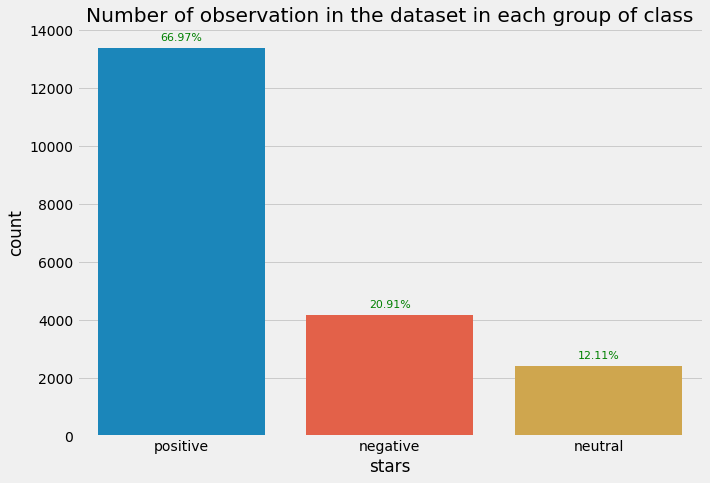

In [38]:
# Distribution of `class`
plt.figure(figsize=(10, 7));
g = sns.countplot(x='stars', data=df)
plt.title('Number of observation in the dataset in each group of class');
ax = g.axes
for p in ax.patches:
     ax.annotate(f"{p.get_height() * 100 / df.shape[0]:.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=11, color='green', rotation=0, xytext=(0, 10),
         textcoords='offset points') 

In [0]:
# Function to clean texts
def clean(x):   
    x = word_tokenize(x) #tokenizing
    x = [word.lower() for word in x] 
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    x = [regex.sub('', word) for word in x if not regex.sub('', word) == ''] #removing punctuation
    wordnet = WordNetLemmatizer()
    x = [wordnet.lemmatize(word) for word in x] #lemmatizing
    x = [word for word in x if not word.lower() in stopwords.words('english')] #removing stopwords
    return ' '.join(x)

In [40]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
# Cleaning text
df['cleaned_text'] = df['text'].apply(clean)

In [42]:
# Displaying several texts after cleaning
for i in range(5):
    np.random.seed(i + 167)
    print(f'TEXT {i + 1}: {df.iloc[np.random.randint(len(df))]["cleaned_text"]} \n')

TEXT 1: serverbartender amanda wa amazing great talk wa sweet also hilarious coming back 

TEXT 2: came early morning around 10am nt run busy traffic waiter waiting food anything like waiter wa nice helped order since wa first time ordered pancake banana wa sweet n tasty like pancake ingredient banana chocolate chip etc actually baked pancake tossed top another great thing pancake actually baked make great difference sooo fluffy inside outer side pancake crispy yummy ate half pancake also ordered breakfast platter 2 sunny side egg warm tasty ate one 2 sizzling sausage ate half 1 evenly cooked hash brown ate spoonful lastly ordered side biscuit gravy omg best ever tasted highly recommend trying come 2 biscuit ate one wanted save one later tried little bit everything nt finish everything food wa nt die order lot food could nt fit everything stomach guess got carried away lol wanted try everything menu 

TEXT 3: walking distance house best coffee consistent service always busy waitstaff b

In [0]:
# Creating dictionary containing all words and their frequencies 
text = ' '.join(df['cleaned_text'].values)
dic = FreqDist(text.split(' '))

In [44]:
print(f'Number of different words in dataset: {len(dic)}')

Number of different words in dataset: 37399


In [45]:
# Top 20 highest frequency words
sorted(dic.items(), key=lambda y: y[1], reverse = True)[:20]

[('wa', 42648),
 ('nt', 15567),
 ('place', 11213),
 ('good', 10910),
 ('food', 10634),
 ('great', 8910),
 ('time', 8526),
 ('like', 7890),
 ('get', 7454),
 ('service', 7338),
 ('one', 7089),
 ('would', 7018),
 ('back', 6074),
 ('really', 5887),
 ('go', 5674),
 ('also', 4643),
 ('got', 4330),
 ('u', 4295),
 ('nice', 4169),
 ('even', 4094)]

(-0.5, 1199.5, 999.5, -0.5)

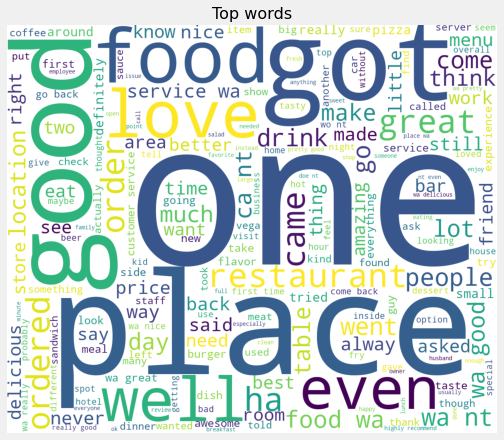

In [46]:
# Using WordCloud to look at most common words
fig, ax = plt.subplots(figsize = (10, 7))
wordcloud = WordCloud(max_font_size=None, background_color='white',
                      width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words', fontsize=16)
plt.axis("off")

#### 2.1.1. TF-IDF features


In [0]:
# Feature extraction using TfidfVectorizer to find (at least) four letter tokens, remove stop_words,
# remove tokens that don't appear in at least 30 documents
# remove tokens that appear in more than 50% of the documents
tfidf = TfidfVectorizer(min_df=30, max_df=0.5, ngram_range=(1,4), stop_words='english', 
                        token_pattern='(?u)\\b\\w\\w\\w+\\b').fit(df['cleaned_text'])

In [48]:
print(f'There are {len(tfidf.get_feature_names())} (group) words in the vocabulary')

There are 4446 (group) words in the vocabulary


In [49]:
# Displaying some words in the vocab
for i in range(5):
    print(tfidf.get_feature_names()[np.random.randint(2720)])

fiancã
decent food
date
greatest
know stuff


In [0]:
# Transforming from text to array tfidf features
X_tfidf = tfidf.transform(df['cleaned_text']).toarray()

In [51]:
print(f'Shape of X_tfidf = {X_tfidf.shape}')

Shape of X_tfidf = (20000, 4446)


#### 2.1.2. Statistical Features

In this section, several features of description are considered, such as: number of characters, number of words, number of different words, number of digits, number of non-words, average characters per word.

In [0]:
df['nb_characters'] = df['cleaned_text'].str.len()
df['nb_words'] = df['cleaned_text'].str.split().str.len()
df['nb_diff_words'] = df['cleaned_text'].apply(lambda x: len(set(x.split())))
df['nb_digits'] = df['cleaned_text'].str.count(r'\d')
df['nb_non_words'] = df['cleaned_text'].str.count(r'\W')
df['avg_characters_per_word'] = (df['nb_characters'] - df['nb_non_words'])/(df['nb_words'] + 1)

In [0]:
X_tfidf = np.c_[
    X_tfidf,
    df['nb_characters'],
    df['nb_words'],
    df['nb_diff_words'],
    df['nb_digits'],
    df['nb_non_words'],
    df['avg_characters_per_word']
]

In [54]:
lb = LabelBinarizer().fit(df['stars'])
print(lb.classes_)
Y =  lb.transform(df['stars'])

['negative' 'neutral' 'positive']


In [0]:
# Split data into training and test sets (as the number of our dataset is quite large, we need only 10% samples in test set)
X_train, X_test, Y_train, Y_test = train_test_split(X_tfidf, Y, test_size=0.1, random_state=167, stratify=df["stars"])

In [56]:
# Check shape:
print('Shape of X_train_tfidf = ', X_train.shape)
print('Shape of X_test_tfidf = ', X_test.shape)
print('Shape of Y_train = ', Y_train.shape)
print('Shape of Y_test = ', Y_test.shape)

Shape of X_train_tfidf =  (18000, 4452)
Shape of X_test_tfidf =  (2000, 4452)
Shape of Y_train =  (18000, 3)
Shape of Y_test =  (2000, 3)


#### 2.1.3. Fully connected neural network

In [0]:
# Load some packages 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

In [0]:
# Creating a neural network model with one hidden layer
model = Sequential()
model.add(Dense(512, activation = 'relu', input_shape = (4452, )))
model.add(BatchNormalization())
model.add(Dropout(0.2)) # to avoid overfitting
model.add(Dense(128, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2)) # to avoid overfitting
model.add(Dense(3, activation = 'softmax'))

In [0]:
# Let's see the architecture and number of training parameters
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               339712    
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 340,353
Trainable params: 340,097
Non-trainable params: 256
_________________________________________________________________


In [0]:
# Define Adam optimization method
opt = Adam(lr = 0.001, decay = 0.01)

In [0]:
# Compile model: using binary crossentropy as loss function and accuracy metrics
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

In [0]:
# Fitting model with 5 epochs and 128 batch size
H = model.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = 30, batch_size = 128)

Epoch 1/30
141/141 [==============================] - 1s 5ms/step - loss: 1.0103 - accuracy: 0.5675 - val_loss: 0.8482 - val_accuracy: 0.6605
Epoch 2/30
141/141 [==============================] - 1s 5ms/step - loss: 0.7498 - accuracy: 0.7158 - val_loss: 0.8290 - val_accuracy: 0.6795
Epoch 3/30
141/141 [==============================] - 1s 5ms/step - loss: 0.6281 - accuracy: 0.7647 - val_loss: 0.8505 - val_accuracy: 0.6810
Epoch 4/30
141/141 [==============================] - 1s 5ms/step - loss: 0.5725 - accuracy: 0.7803 - val_loss: 0.6790 - val_accuracy: 0.7360
Epoch 5/30
141/141 [==============================] - 1s 5ms/step - loss: 0.5499 - accuracy: 0.7914 - val_loss: 0.5423 - val_accuracy: 0.7915
Epoch 6/30
141/141 [==============================] - 1s 5ms/step - loss: 0.5210 - accuracy: 0.8021 - val_loss: 0.6944 - val_accuracy: 0.7400
Epoch 7/30
141/141 [==============================] - 1s 5ms/step - loss: 0.4965 - accuracy: 0.8068 - val_loss: 0.4947 - val_accuracy: 0.8060
Epoch 

By training only 20 epochs in short time, the training set give **~87% accuracy** and **~80% accuracy** in test sets. This result is significant, this may due to the small number of parameters using the model and not much large size of database.

#### 2.1.4. Random forest

In [0]:
rf = RandomForestClassifier(n_estimators = 500, bootstrap = True, max_features = 'sqrt')

In [0]:
rf.fit(X_train, lb.inverse_transform(Y_train))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
rf.score(X_train, lb.inverse_transform(Y_train))

0.9999444444444444

In [0]:
rf.score(X_test, lb.inverse_transform(Y_test))

0.776

#### 2.1.5. Gradient Boosting

In [0]:
gb = GradientBoostingClassifier(n_estimators = 500, max_features = 'sqrt')

In [0]:
gb.fit(X_train, lb.inverse_transform(Y_train))

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=500,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [0]:
gb.score(X_train, lb.inverse_transform(Y_train))

0.8699444444444444

In [0]:
gb.score(X_test, lb.inverse_transform(Y_test))

0.802

#### 2.1.6 XGBoost and LightGBM

In [0]:
import xgboost as xgb
import lightgbm as lgb

In [0]:
XGB = xgb.XGBClassifier(learning_rate = 0.1, n_estimators = 500, colsample_bytree = 0.8, subsample = 0.6,
                                            nthread = 4, seed = 27)

In [0]:
XGB.fit(X_train, lb.inverse_transform(Y_train))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=4, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
              silent=None, subsample=0.6, verbosity=1)

In [0]:
XGB.score(X_train, lb.inverse_transform(Y_train))

0.8719444444444444

In [0]:
XGB.score(X_test, lb.inverse_transform(Y_test))

0.8075

In [0]:
lightgbm = lgb.LGBMClassifier(learning_rate = 0.1, n_estimators = 500, feature_fraction = 0.8, 
                              bagging_fraction = 0.8, max_depth = 3, num_leaves = 10, reg_lambda = 1, n_jobs = -1)

In [0]:
lightgbm.fit(X_train, lb.inverse_transform(Y_train))

LGBMClassifier(bagging_fraction=0.8, boosting_type='gbdt', class_weight=None,
               colsample_bytree=1.0, feature_fraction=0.8,
               importance_type='split', learning_rate=0.1, max_depth=3,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=500, n_jobs=-1, num_leaves=10, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=1, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [0]:
lightgbm.score(X_train, lb.inverse_transform(Y_train))

0.8593888888888889

In [0]:
lightgbm.score(X_test, lb.inverse_transform(Y_test))

0.801

### 2.2. Model 2: Predict positive/negative/neutral comment using LSTM model



In [0]:
# Import somme packages
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np

max_len = 250 #Cuts off reviews after 250 words
max_words = 20000 #Considers only the top 20,000 words in the dataset

Let’s vectorize the text and prepare a training and validation split. We’ll restrict the reviews to the top 20,000 most common words and cut off the reviews after only 250 words. The network will learn 300-dimensional embeddings for each of the 20,000 words, turn the input integer sequences (2D integer tensor) into embedded sequences (3D float tensor).

Note that Keras has built-in utilities for doing one-hot encoding of text at the word level or character level, starting from raw text data. They take care of a number of important features such as stripping special characters from strings and only taking into account the N most common words in the dataset (a common restriction, to avoid dealing with very large input vector spaces).

In [0]:
# Tokenizing the text of the raw data
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text']) # obtain lists of integers (position of token in the vocabulary)

In [0]:
# Display number of tokens in vocabulary
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 39652 unique tokens.


In [0]:
# Turns the lists of integers into a 2D integer tensor of shape (samples, max_len)
data = pad_sequences(sequences, maxlen=max_len)

In [0]:
# Check data's shape
data.shape

(20000, 250)

In [0]:
# Split data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(data, Y, test_size=0.1, random_state=167, stratify=df["stars"])

#### 2.2.1. Embedding layers of GloVe300


In Keras, the embedding matrix is represented as a "layer", and maps positive integers (indices corresponding to words) into dense vectors of fixed size (the embedding vectors). It can be trained or initialized with a pretrained embedding. In this part, we will initialize it with the GloVe 300-dimensional vectors (https://nlp.stanford.edu/projects/glove). Because our training set is quite large, we will update the word embeddings instead leave their values fixed (fine-tuning).  

The `Embedding()` layer takes an integer matrix of size (batch size, max_len) as input. This corresponds to sentences converted into lists of indices (integers).


In [0]:
# (GLOVE WORD EMBEDDINGS - https://nlp.stanford.edu/projects/glove)
urllib.request.urlretrieve(
    "http://nlp.stanford.edu/data/glove.6B.zip", 
    "glove.6B.zip"
)

('glove.6B.zip', <http.client.HTTPMessage at 0x7fef47412fd0>)

In [0]:
import zipfile

# Unzip file
with zipfile.ZipFile("glove.6B.zip") as zf:
    zf.extractall("glove.6B")

In [0]:
# Preprocessing the precomputed embeddings

embeddings_index = {}
f = open('glove.6B/glove.6B.300d.txt', encoding = 'utf-8-sig')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
# Preparing the GloVe word-embeddings matrix
embedding_dim = 300

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

#### 2.2.2. LSTM model

Lets now build our model. We will do so using the embedding layer we have built, and feed its output to an LSTM network.

In [0]:
# Importing some packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense

# Model definition
model2 = Sequential() 
model2.add(Embedding(max_words, embedding_dim, input_length=max_len)) # Create the embedding layer

# Propagate the embeddings through two LSTM layers with 128-dimensional hidden state and Add dropout to avoid overfitting
model2.add(Bidirectional(LSTM(128, return_sequences = True, dropout=0.1, recurrent_dropout=0.3)))
model2.add(Bidirectional(LSTM(128, return_sequences = False, dropout=0.1, recurrent_dropout=0.3)))
model2.add(Dense(64, activation='relu'))
# Propagate X through a Dense layer with softmax activation to get back a batch of 3-dimensional vectors
model2.add(Dense(3, activation='softmax'))

In [0]:
# Loading pretrained word embeddings into the Embedding layer
model2.layers[0].set_weights([embedding_matrix])

In [0]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 250, 300)          6000000   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 250, 256)          439296    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 195       
Total params: 6,850,179
Trainable params: 6,850,179
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Define what loss, optimizer and metrics. Compile the model using  categorical_crossentropy loss, adam optimizer and ['accuracy'] metrics
opt = Adam(lr = 1e-4, decay = 0.01)
model2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [0]:
check_point = ModelCheckpoint('model2.hdf5', monitor='val_acc', mode='max', save_best_only=True, verbose=1)
early_stop = EarlyStopping(patience=5)

In [0]:
# Training model
H = model2.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=15, batch_size=32, shuffle=True)

Epoch 1/15
563/563 [==============================] - 1641s 3s/step - loss: 0.7093 - accuracy: 0.7199 - val_loss: 0.6150 - val_accuracy: 0.7720
Epoch 2/15
563/563 [==============================] - 1652s 3s/step - loss: 0.5896 - accuracy: 0.7764 - val_loss: 0.5996 - val_accuracy: 0.7830
Epoch 3/15
563/563 [==============================] - 1639s 3s/step - loss: 0.5697 - accuracy: 0.7826 - val_loss: 0.5737 - val_accuracy: 0.7875
Epoch 4/15
563/563 [==============================] - 1640s 3s/step - loss: 0.5567 - accuracy: 0.7877 - val_loss: 0.5676 - val_accuracy: 0.7915
Epoch 5/15
563/563 [==============================] - 1645s 3s/step - loss: 0.5504 - accuracy: 0.7908 - val_loss: 0.5635 - val_accuracy: 0.7930
Epoch 6/15
563/563 [==============================] - 1639s 3s/step - loss: 0.5464 - accuracy: 0.7922 - val_loss: 0.5659 - val_accuracy: 0.7910
Epoch 7/15
563/563 [==============================] - 1639s 3s/step - loss: 0.5428 - accuracy: 0.7930 - val_loss: 0.5602 - val_accuracy:

After training only 15 epochs, we obtain a validation accuracy of ~80%, which is pretty good while we consider only the first 250 words of inputs, rather than full sequences of sentences (the LSTM has access to less information). 

**Note:** "*The primary reason is that analyzing the global, long-term structure of the reviews (what LSTM is good at) isn’t helpful for a sentiment-analysis problem. Such a basic problem is well solved by looking at what words occur in each review, and at what frequency. That’s what the fully connected approach looked at. But there are far more difficult natural language-processing problems out there, where the strength of LSTM will become apparent: in particular, question-answering and machine translation.*" - François Chollet, creator of the Keras deep-learning library.

In [0]:
# Saving model after 8 epochs
model.save('drive/My Drive/Yelp/multiple_2lstm_8epochs.hdf5')

In [0]:
from keras.models import load_model

# load trained model
model = load_model('drive/My Drive/Yelp/multiple_2lstm_8epochs.hdf5')

Using TensorFlow backend.


## 2.3. Model 3 - BERT


In [0]:
!pip install transformers

     |████████████████████████████████| 573kB 4.4MB/s 
     |████████████████████████████████| 3.7MB 11.5MB/s 
     |████████████████████████████████| 870kB 46.2MB/s 
     |████████████████████████████████| 1.0MB 45.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=6cca1546a2d890b72a1dbb458b5c38e4f6bc98edddad87f72e14402ea2d12f2b
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


In [0]:
from transformers import TFBertModel, BertTokenizer
from tensorflow.keras.utils import Sequence, to_categorical

#### 2.3.1. Creating data generator

In [0]:
class DataGenerator(Sequence):
    def __init__(self, texts, labels, maxlen, batch_size=32):
        
        self.texts = texts
        self.labels = labels
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
        self.maxlen = maxlen
        self.batch_size = batch_size
        self.on_epoch_end()
        

    def on_epoch_end(self):
        self.indices = np.arange(len(self.texts))
        np.random.shuffle(self.indices)


    def __len__(self):
        return int(np.ceil(len(self.texts) / self.batch_size))
    
    
    def __getitem__(self, idx):
        curr_batch = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_len = len(curr_batch)  

        y = np.zeros((batch_len, 3), dtype=np.float32)       
        ids = []
        masks = []
        type_ids = []

        for i, index in enumerate(curr_batch):
            text = self.texts[index]
            inputs = self.tokenizer.encode_plus(text, None, add_special_tokens=True, max_length=self.maxlen)
            input_ids = inputs["input_ids"]
            attention_mask = inputs["attention_mask"]
            token_type_ids = inputs["token_type_ids"]

            padding_lengths = self.maxlen - len(input_ids)
            ids.append(input_ids + [0]*padding_lengths)
            masks.append(attention_mask + [0]*padding_lengths)
            type_ids.append(token_type_ids + [0]*padding_lengths)
            y[i] = self.labels[index]
        
        return [
            tf.constant(ids, dtype=tf.int32), 
            tf.constant(masks, dtype=tf.int32),
            tf.constant(type_ids, dtype=tf.int32)
        ], y

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(df["text"], Y, test_size=0.1, random_state=167, stratify=df["stars"])

In [0]:
train_generator = DataGenerator(X_train.reset_index(drop=True), Y_train, maxlen=256)
test_generator = DataGenerator(X_test.reset_index(drop=True), Y_test, maxlen=256)

In [0]:
data_exp = next(iter(train_generator))

#### 2.3.2. Training model

In [0]:
class SentimentClassifier(tf.keras.Model):

    def __init__(self):
        super(SentimentClassifier, self).__init__()
        self.bert = TFBertModel.from_pretrained("bert-base-uncased")
        self.drop = tf.keras.layers.Dropout(0.3)
        self.out = tf.keras.layers.Dense(3, activation="softmax")

    def call(self, inputs):
        # ids, masks, token_type_ids = inputs
        _, x = self.bert(inputs)
        x = self.drop(x)
        x = self.out(x)
        return x


In [0]:
model = SentimentClassifier()

In [0]:
out_test = model(data_exp[0])

In [0]:
model.summary()

Model: "sentiment_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tf_bert_model (TFBertModel)  multiple                  109482240 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  2307      
Total params: 109,484,547
Trainable params: 109,484,547
Non-trainable params: 0
_________________________________________________________________


In [0]:
opt = tf.keras.optimizers.Adam(lr = 3e-5, decay = 0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [0]:
check_point = ModelCheckpoint('model3.hdf5', monitor='val_acc', mode='max', save_best_only=True, verbose=1)
early_stop = EarlyStopping(patience=3)

In [0]:
model.fit_generator(train_generator, validation_data = test_generator, steps_per_epoch=len(train_generator), epochs=10, callbacks=[check_point, early_stop])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
563/563 [==============================] - 555s 985ms/step - loss: 0.4258 - accuracy: 0.8306 - val_loss: 0.3537 - val_accuracy: 0.8655
Epoch 2/10
563/563 [==============================] - 551s 979ms/step - loss: 0.2919 - accuracy: 0.8872 - val_loss: 0.3403 - val_accuracy: 0.8670
Epoch 3/10
563/563 [==============================] - 551s 979ms/step - loss: 0.2568 - accuracy: 0.9011 - val_loss: 0.3451 - val_accuracy: 0.8620
Epoch 4/10
563/563 [==============================] - 552s 980ms/step - loss: 0.2341 - accuracy: 0.9102 - val_loss: 0.3612 - val_accuracy: 0.8645
Epoch 5/10
563/563 [==============================] - 552s 980ms/step - loss: 0.2183 - accuracy: 0.9180 - val_loss: 0.3659 - val_accuracy: 0.8620
